### Import libraries and get data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

## Preprocessing data

In [4]:
# Load the dataset
df = pd.read_csv("./USDT.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Format the 'Date' column
# df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Price,Vol.
Date,,
2017-12-01,1.0100,457.32K
2017-12-02,0.9959,970.82K
2017-12-03,0.9977,1.30M
2017-12-04,1.0000,2.91M
2017-12-05,1.0000,1.74M
...,...,...
2023-03-28,1.0001,135.75M
2023-03-29,0.9999,169.26M
2023-03-30,1.0000,139.94M


In [5]:
# Split the data into training (70%) and test (30%) sets
train_size = int(0.7 * len(df))

train = df[:train_size][['Price']]
test = df[train_size:][['Price']]

# Check the sizes of the data sets
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1362, 1)
Test shape: (585, 1)


## ARIMA Model

### 3. Perfom ARIMA Model 

In [6]:
!pip install pmdarima


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
arima_model = pmd.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11684.760, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3868.101, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-11723.739, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-11721.681, Time=0.52 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-11723.605, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.65 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-11721.615, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-11756.317, Time=0.40 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-11102.504, Time=1.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-11738.216, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-11748.509, Time=0.62 sec
 ARIMA(1,0,3)(0,0

### 3.1 Build the ARIMA Model

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# ARMIA(1,0,2)
model = ARIMA(train, order=(1,0,2))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1362
Model:                 ARIMA(1, 0, 2)   Log Likelihood                5888.000
Date:                Wed, 03 May 2023   AIC                         -11765.999
Time:                        15:55:58   BIC                         -11739.916
Sample:                             0   HQIC                        -11756.235
                               - 1362                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0003      0.001    918.580      0.000       0.998       1.002
ar.L1          0.9526      0.005    187.338      0.000       0.943       0.963
ma.L1         -0.2626      0.013    -19.787      0.0

### 3.2 Predict on Test data

1363    1.000350
1364    1.000349
1365    1.000347
1366    1.000345
1367    1.000344
          ...   
1943    1.000313
1944    1.000313
1945    1.000313
1946    1.000313
1947    1.000313
Name: predicted_mean, Length: 585, dtype: float64


C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


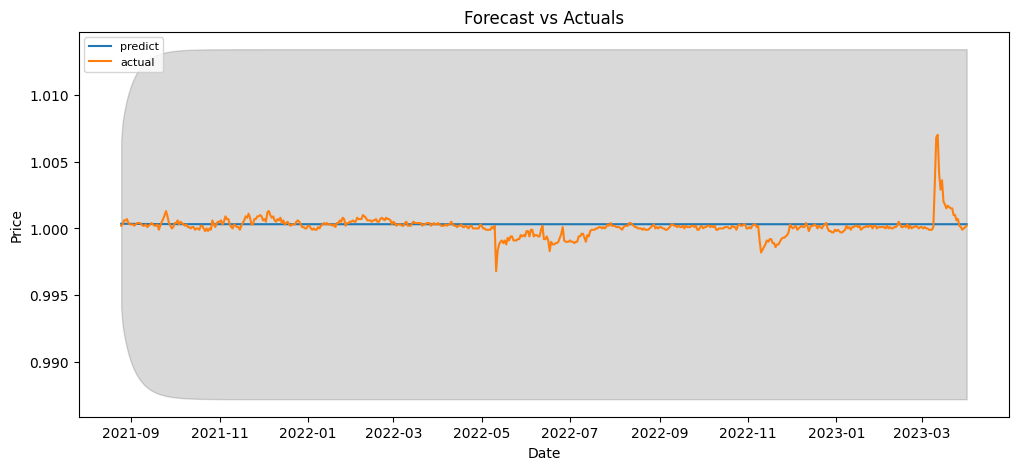

In [9]:
# Forecast
for t in range(len(test)):
    model = ARIMA(train, order=(1,0,2))
    model_fit = model.fit()
    yhat_f = model_fit.forecast()[0][0]
    yhat_p = model_fit.predict(start=len(history), end=len(history))[0]
    predictions_f.append(yhat_f)
    predictions_p.append(yhat_p)
    history.append(test[t])

predict_results = model_fit.get_forecast(585)


# Confidence
conf = predict_results.conf_int(alpha=0.05)

# Make as pandas series
predict = pd.Series(predict_price.values, index=test.index)
lower = pd.Series(conf['lower Price'].values, index=test.index)
upper = pd.Series(conf['upper Price'].values, index=test.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(predict, label='predict')
plt.plot(test, label='actual')
plt.fill_between(lower.index, lower, upper, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 3.3 Predict 10 days later

In [10]:
price_30_days_later = model_fit.predict(start=1948, end=1978)
price_30_days_later

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1948    1.000313
1949    1.000313
1950    1.000313
1951    1.000313
1952    1.000313
1953    1.000313
1954    1.000313
1955    1.000313
1956    1.000313
1957    1.000313
1958    1.000313
1959    1.000313
1960    1.000313
1961    1.000313
1962    1.000313
1963    1.000313
1964    1.000313
1965    1.000313
1966    1.000313
1967    1.000313
1968    1.000313
1969    1.000313
1970    1.000313
1971    1.000313
1972    1.000313
1973    1.000313
1974    1.000313
1975    1.000313
1976    1.000313
1977    1.000313
1978    1.000313
Name: predicted_mean, dtype: float64

### 4.  Evaluate ARIMA Model

In [11]:
#MAPE
def mean_absolute_percentage_error(predict, actual):
    return np.mean(np.abs(predict - actual)/np.abs(actual))

mean_absolute_percentage_error(predict, test['Price'])

0.00042007528036060285

In [12]:
#MAE
mean_absolute_error(test['Price'], predict)

0.00042020880033603116

In [13]:
#MSE
mean_squared_error(test['Price'], predict)

5.328163254338276e-07